In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from lib.creditcard_fraud_dataset import get_train_test_dfs, X_COLS

# 3. Cost-sensitive sampling

In the previous notebook, we just wanted to get the same number of positives (fraudulent transactions) and negatives (non-fraudulent transactions). However, we could also choose the number of positives and negatives **that takes the costs into account**.

We will resample data such that the positive-negative ratio is equal to:

$$
r_{cs} = \frac{|N^+|}{|N^-|}\cdot\frac{C_{FN}}{C_{FP}},
$$

with $|N^+|$ and $|N^-|$ the original number of positive, resp. negative, classes and $C_{FN}$, $C_{FP}$ the cost of false negative and false positive, respectively.

Note that the costs for a false negative and false positive classification vary for each transaction, so each transaction yields a different ratio. To obtain a global ratio, we will compute the **average all record-specific ratios**.

## 3.1 Train

In [2]:
df_train, df_test = get_train_test_dfs()

### 3.1.1 Run training *without* balancing

First, we'll run a training with the original (unbalanced) dataset.

In [3]:
X_train = df_train[X_COLS]
y_train = df_train['Class']

In [4]:
# Create a logistic regression classifier
clf_no_cs = LogisticRegression(max_iter=500)

# Train it on X_train and y_train
clf_no_cs.fit(X_train, y_train)

LogisticRegression(max_iter=500)

### 3.1.2 Run training *with* balancing

Next, we will balance the dataset by using **the same number of negatives and positives**. More specifically, we will **subsample the number of negatives** until it is equal to the number of positives.

To start, let's first compute the number of fraudulent transactions.

In [5]:
def get_cost_sensitive_sampling_ratios(df_train):
    """
    Return the cost-sensitive sampling ratio of each record.
    
    Args:
        df_train: The training dataframe. It should contain the columns
            "Class", "C_FN" and "C_FP" with the class, false negative cost
            and false positive cost, respectively.
    """
    num_fraud = df_train['Class'].sum()
    num_no_fraud = len(df_train) - num_fraud

    return (df_train['C_FN'] / df_train['C_FP']) * (num_fraud / num_no_fraud)

To balance the dataset, we  will do the same as in the previous notebook, but will now use the **cost-sensitive positive-negative ratio** to determine the number of non-fraudulent transactions to sample.

In [6]:
# Define X_fraud
is_fraud = y_train == 1
X_fraud = X_train[is_fraud]

In [7]:
# Compute cost-sensitive positive-negative ratio
record_spec_r_cs = get_cost_sensitive_sampling_ratios(df_train)
global_r_cs = record_spec_r_cs.mean()

# Compute number of non-fraudulent transactions to sample
num_fraud = len(X_fraud)
num_no_fraud_sample = int(num_fraud / global_r_cs)

In [8]:
# Define X_no_fraud by sampling from all non-fraudulent rows
no_fraud = y_train == 0
X_no_fraud = X_train[no_fraud]
X_no_fraud = X_no_fraud.sample(n=num_no_fraud_sample)

In [9]:
X_cs = pd.concat([X_fraud, X_no_fraud])
y_cs = np.concatenate([np.ones(len(X_fraud)),
                       np.zeros(len(X_no_fraud))])

In [10]:
# Train the classifier
clf_cs = LogisticRegression(max_iter=500)
clf_cs.fit(X_cs, y_cs)

LogisticRegression(max_iter=500)

## 3.2 Evaluate

In [11]:
X_test = df_test[X_COLS]   # Model inputs
y_test = df_test['Class']  # Expected outputs

In [12]:
# Predictions of classifier without cost-sensitive sampling
y_pred_no_cs = clf_no_cs.predict(X_test)

# Predictions of classifier with cost-sensitive sampling
y_pred_cs = clf_cs.predict(X_test)

In [13]:
from lib.cs_eval import evaluate_pred

# Get the transaction amounts
amounts = df_test['Amount']

# Compute metrics for each classifier
eval_metrics_no_cs = evaluate_pred(y_test, y_pred_no_cs, amounts)
eval_metrics_cs    = evaluate_pred(y_test, y_pred_cs,    amounts)

In [14]:
df = pd.DataFrame([
    {
        'Method': 'Without cost-sensitive sampling',
        **eval_metrics_no_cs
    },
    {
        'Method': 'With cost-sensitive sampling',
        **eval_metrics_cs
    }
])

In [15]:
df

,Method,Cost Precision,Cost Recall,TP Amount,FP Amount,FN Amount,Net Recovered Amount
0,Without cost-sensitive sampling,0.997766,0.514306,16075.45,36.0,15181.12,858.33
1,With cost-sensitive sampling,0.978036,0.800632,25025.00,562.0,6231.57,18231.43


<AxesSubplot:xlabel='Method', ylabel='Cost Recall'>

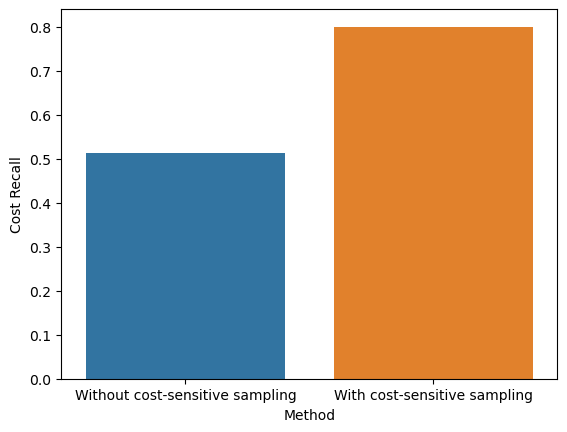

In [16]:
sns.barplot(data=df, x='Method', y='Cost Recall')

<AxesSubplot:xlabel='Method', ylabel='Cost Precision'>

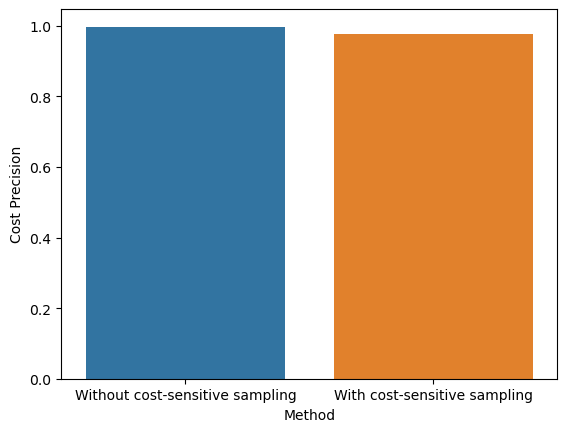

In [17]:
sns.barplot(data=df, x='Method', y='Cost Precision')